<a href="https://colab.research.google.com/github/halloweex/data-analysis/blob/master/hotdog/_Hotdog_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#импортируем необходимые библиотеки

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm

%matplotlib inline

In [ ]:
#определим устройство, где проводить вычисления (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# необходимо раcпаковать датасет в окружение, делается это так:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/hd/hotdog.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset_hd')
  

In [ ]:
#функция для вывода изображений
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("hotgot", "not_hot_dog")

#путь до датасета
PATH = "/content/dataset_hd/hotdog"

In [ ]:
# зададим какие преобразования необходимо сделать с каждым изображением
transform = transforms.Compose(
    [transforms.Resize((64,64)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test/"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=True)


Real Labels:  not_hot_dog not_hot_dog not_hot_dog hotgot


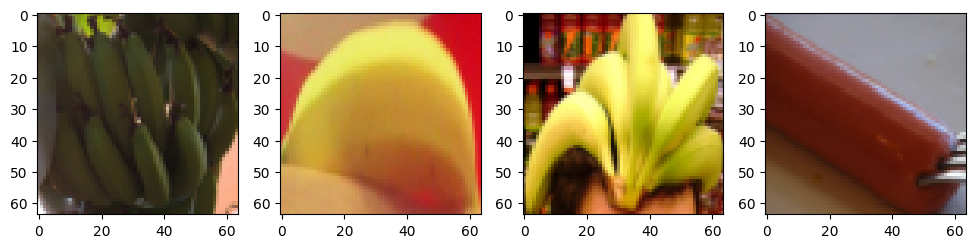

In [ ]:
#Проверим как работает наш загрузчик и посмотрим на парочку изображений
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [ ]:
#загрузим нашу модель
model = torchvision.models.resnet18(pretrained=True)
#заморозим веса
for param in model.parameters():
    param.require = False

#так как у нас 2 класса, нужно переопределить последний слой сети под нашу задачу
#у предобученной сети было на выходе 1000 классов, поэтому в видео я сказал меняем 1000 на 2
model.fc = nn.Linear(512, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In [ ]:
#Зададим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
#Здесь будет тренировка нейронной сети

epochs = 10   #количество эпох (сколько раз будем тренировать)
model.to(device) #переносим нашу модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    #теперь в цикле проходим по нашему загрузчику данных
    for i, data in tqdm(enumerate(trainloader)):
        #каждый батч тоже помещаем на GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #сбрасываем накопленный градиент 
        optimizer.zero_grad()
        #прогоняем изображения через модель, чтобы получить предсказание
        outputs = model(inputs)
        #рассчитываем функцию потерь (насколько хорошо предсказали)
        loss = criterion(outputs, labels)
        #считаем градиенты (обратный проход)
        loss.backward()
        #делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

32it [00:14,  2.17it/s]


Epoch 0 - Training loss: 0.536404550075531 


32it [00:09,  3.53it/s]


Epoch 1 - Training loss: 0.18648788728751242 


32it [00:08,  4.00it/s]


Epoch 2 - Training loss: 0.10159398836549371 


32it [00:07,  4.34it/s]


Epoch 3 - Training loss: 0.06590369512559846 


32it [00:08,  3.92it/s]


Epoch 4 - Training loss: 0.04969263047678396 


32it [00:08,  3.89it/s]


Epoch 5 - Training loss: 0.02676993963541463 


32it [00:07,  4.00it/s]


Epoch 6 - Training loss: 0.021308689611032605 


32it [00:07,  4.36it/s]


Epoch 7 - Training loss: 0.015763616131152958 


32it [00:07,  4.02it/s]


Epoch 8 - Training loss: 0.012051894635078497 


32it [00:07,  4.06it/s]

Epoch 9 - Training loss: 0.013080156742944382 


In [ ]:
#посчитаем точность работы нашего классификатора
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))


Accuracy: 91


Real Labels:  hotgot hotgot not_hot_dog hotgot
Predicted:  hotgot hotgot not_hot_dog hotgot


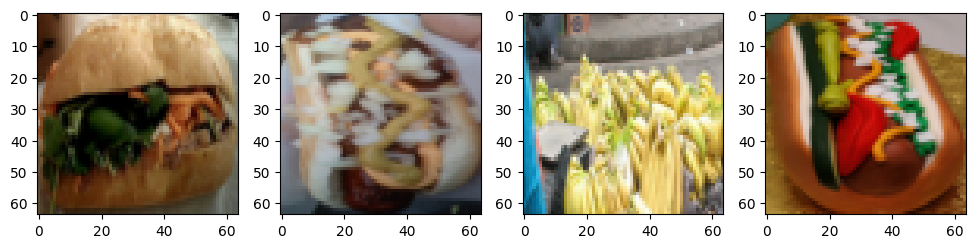

In [ ]:
images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))

In [ ]:
Спасибо за просмотр!!